In [ ]:
# genaric imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#Kmeans
from sklearn.cluster import KMeans
#DecisionTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import altair as alt

In [ ]:
#read in data set
rootDir="drive/MyDrive/GQG/"
data= pd.read_csv(rootDir+"OriginalData.csv")

In [ ]:
#convert dates to datetime
data["Dates"] = pd.to_datetime(data["Dates"])
data["DATE_OF_LAST_BOD_CHANGE"] = pd.to_datetime(data["DATE_OF_LAST_BOD_CHANGE"])
data["DATE_OF_LAST_EXECUTIVE_CHANGE"] = pd.to_datetime(data["DATE_OF_LAST_EXECUTIVE_CHANGE"])
data['COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT'] = pd.to_datetime(data['COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT'], format='%Y%m%d')

In [ ]:
data.drop("Unnamed: 0",axis=1,inplace=True)
data.drop( data[data["Year"]==2014].index,inplace=True)

In [ ]:
# add aditinal coulomns
# add columns to Data_compensation

#CEO
data["equity_Compensation_CEO"] = data['TOT_STK_AWD_GIVEN_TO_CEO_EQUIV']+data["TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV"]
data["cash_incentive_CEO"] = data['TOT_BONUSES_PAID_TO_CEO_EQUIV']+data['TOT_N_EQT_INCENT_GVN_TO_CEO_EQ']
data["Variable_Pay_CEO"] = data["cash_incentive_CEO"]+data["equity_Compensation_CEO"]
data["cash_incentive_CEO_percent"] = data["cash_incentive_CEO"]/data["Variable_Pay_CEO"].replace(0, float('nan'))
data["fixed_Pay_CEO"] = data['TOT_SALARIES_PAID_TO_CEO_EQUIV']/data["NUM_CEOS_EQUIV_INC_COMP_PD"]

#EXECS
data["equity_Compensation_EXECS"] = (data['TOT_STK_AWARDS_GIVEN_TO_EXECS']+data["TOT_OPTION_AWARDS_GIVEN_TO_EXECS"])
data["cash_incentive_EXECS"] = data['TOTAL_BONUSES_PAID_TO_EXECUTIVES']+data['TOT_N_EQTY_INCENT_GIVEN_TO_EXECS']- data["cash_incentive_CEO"]
data["Variable_Pay_EXECS"] = data["equity_Compensation_EXECS"]+data["cash_incentive_EXECS"]-data["Variable_Pay_CEO"]
data["cash_incentive_EXECS_percent"] = data["cash_incentive_EXECS"]/(data["Variable_Pay_EXECS"].replace(0, float('nan')))

In [ ]:
data_temp=data[(data["symbol"]=="AAPL")&(data["DATE_OF_LAST_EXECUTIVE_CHANGE"]=="2014-05-29")][["symbol","DATE_OF_LAST_EXECUTIVE_CHANGE","Dates","PX_LAST"]].copy()

In [ ]:
def get_date(data,key):
  dates_change = []
  dates=data[key].unique()
  dates_change.append((min(dates),min(data["Dates"])))
  for i in dates:
    if i >min(data["Dates"]):
      dates_change.append((i,data[(data['Dates']>=i)]["Dates"].iloc[0]))
  dates_change.append((max(dates),max(data["Dates"])))
  return dates_change

In [ ]:
#2.0
def get_date(data, key):
    if key not in data.columns:
        raise ValueError(f"The key '{key}' is not a column in the DataFrame.")

    if "Dates" not in data.columns:
        raise ValueError("The DataFrame must contain a 'Dates' column.")

    dates_change = []
    dates = sorted(data[key].dropna().unique())
    min_date = min(data["Dates"])
    max_date = max(data["Dates"])

    dates_change.append((min(dates), min_date))

    # Loop through dates to find the next corresponding date
    for i in dates:
        if i > min_date:
            filtered_dates = data[data["Dates"] >= i]["Dates"]
            if not filtered_dates.empty:
                dates_change.append((i, filtered_dates.iloc[0]))
            else:
                # Handle the case where no matching date exists
                #dates_change.append((i, None))
                print("missing date for  {},{}".format(symbol,i))


    # Append the last mapping
    dates_change.append((max(dates), max_date))

    return dates_change


In [ ]:

Columns=["gics_sector_name","symbol","DATE_OF_LAST_CHANGE","avg_cash_incentive_percent","returns","role"]
df = pd.DataFrame(columns=Columns)
for gics_sector_name,data1 in data.groupby("gics_sector_name"):
  for symbol, data2 in data1.groupby("symbol"):

    #CEO change
    dates_CEO_change = get_date(data2,"COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT")
    #print("{} , {}".format(symbol,gics_sector_name))
    for i in range(len(dates_CEO_change)-1):
      returns =  data2[data2["Dates"] == dates_CEO_change[i+1][1]]["PX_LAST"].iloc[0]/data2[data2["Dates"] == dates_CEO_change[i][1]]["PX_LAST"].iloc[0]
      DATE_OF_LAST_CHANGE = dates_CEO_change[i][0]
      avg_cash_incentive_percent=data2[data2["COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT"] == DATE_OF_LAST_CHANGE]["cash_incentive_CEO_percent"].mean()
      #print("{},{}".format(returns,avg_cash_incentive_CEO_percent))

      df2= {
            "gics_sector_name":gics_sector_name,
            "symbol":symbol,
            "DATE_OF_LAST_CHANGE":DATE_OF_LAST_CHANGE,
            "avg_cash_incentive_percent":avg_cash_incentive_percent,
            "returns":returns,
            "role":"CEO"

            }
      df = df._append(df2, ignore_index = True)

    #execuative change
    dates_execuative_change = get_date(data2,"DATE_OF_LAST_EXECUTIVE_CHANGE")
    #print("{} , {}".format(symbol,gics_sector_name))
    for i in range(len(dates_execuative_change)-1):
      returns =  data2[data2["Dates"] == dates_execuative_change[i+1][1]]["PX_LAST"].iloc[0]/data2[data2["Dates"] == dates_execuative_change[i][1]]["PX_LAST"].iloc[0]
      DATE_OF_LAST_CHANGE = dates_execuative_change[i][0]
      avg_cash_incentive_percent=data2[data2["DATE_OF_LAST_EXECUTIVE_CHANGE"] == DATE_OF_LAST_CHANGE]["cash_incentive_EXECS_percent"].mean()
      #print("{},{}".format(returns,avg_cash_incentive_CEO_percent))

      df2= {
                  "gics_sector_name":gics_sector_name,
                  "symbol":symbol,
                  "DATE_OF_LAST_CHANGE":DATE_OF_LAST_CHANGE,
                  "avg_cash_incentive_percent":avg_cash_incentive_percent,
                  "returns":returns,
                  "role":"execuative"

          }
      df = df._append(df2, ignore_index = True)




    #board change



    #print("------------------------------------------")



<ipython-input-9-98afd8db8127>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(df2, ignore_index = True)
<ipython-input-9-98afd8db8127>:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(df2, ignore_index = True)


missing date for  CAT,2023-12-31 00:00:00
missing date for  SO,2023-12-31 00:00:00


In [ ]:
def plot_data(df,sector_index=-1):
  sector_names = data["gics_sector_name"].unique()

  if sector_index>-1:
    plot_title= sector_names[sector_index]
    df_plot= df[df["gics_sector_name"]==plot_title]
    color_name = "symbol"

  else:
    plot_title= "All sectors"
    df_plot = df

    color_name = "gics_sector_name"

  line = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule().encode(y='y')
  chart=alt.Chart(df_plot).mark_point().encode(
      x='avg_cash_incentive_percent',
      y='returns',
      tooltip=["avg_cash_incentive_percent","returns","gics_sector_name","symbol","role"],
      color = color_name,
      shape="role:N"
  ).properties(
    title=plot_title).interactive()
  return line+chart

In [ ]:
plot_data(df,-1)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,0)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,1)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,2)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,3)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,4)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,5)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,6)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,7)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,8)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,9)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
plot_data(df,10)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

<Axes: xlabel='Dates', ylabel='PX_LAST'>

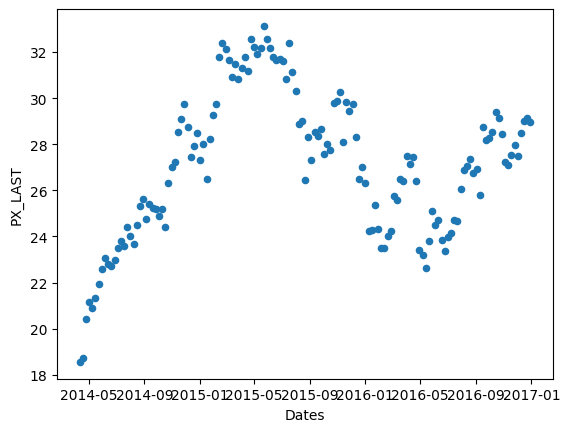

In [ ]:
data_temp.plot(kind="scatter",x="Dates",y="PX_LAST")

<Axes: xlabel='Dates', ylabel='PX_LAST'>

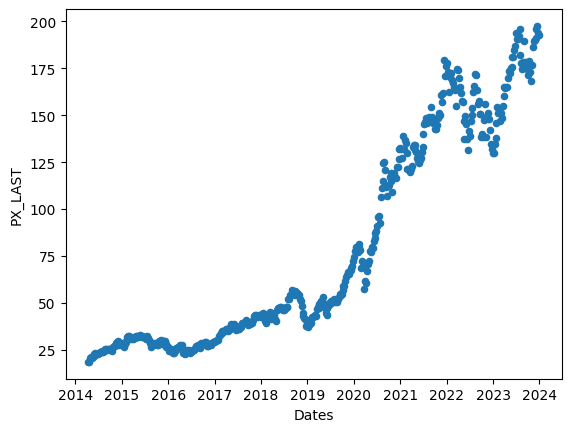

In [ ]:
data[data["symbol"]=="AAPL"].plot(kind="scatter",x="Dates",y="PX_LAST")

In [ ]:
#fix me
#*compute the average  return for eache compensation pakege
last_returns =data.groupby("symbol")["PX_LAST"].apply(lambda x: (x.iloc[-1]/x.iloc[0])**0.1).reset_index()

In [ ]:
#cash_incentive_EXECS_percent
#get returns for every Dates change (vertical axis)
#data.groupby(["symbol","DATE_OF_LAST_EXECUTIVE_CHANGE"])[["PX_LAST"].apply(lambda x: (x.iloc[-1]/x.iloc[0])**0.1).reset_index()
#data.groupby(["symbol","DATE_OF_LAST_EXECUTIVE_CHANGE"])[["PX_LAST"].mean().reset_index()
